 Demand Forecasting Project 

Import Libraries & Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from prophet import Prophet



c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [11]:
# Load dataset
df = pd.read_csv("demand_data.csv", parse_dates=["date_column"])

 Missing Values
 Check if any columns have nulls.



In [4]:
print(df.isnull().sum())


date_column    0
demand         0
dtype: int64



Data Types
 Ensure columns have correct types (e.g., date_column as datetime, demand as numeric).


In [5]:
print(df.dtypes)
df["date_column"] = pd.to_datetime(df["date_column"])
df["demand"] = pd.to_numeric(df["demand"])

date_column    datetime64[us]
demand                  int64
dtype: object


- Duplicates
- Check if rows are repeated.
- Drop duplicates if they don’t add value.



In [6]:
print(df.duplicated().sum())
df = df.drop_duplicates()

0


- Outliers
- Detect extreme values using Z-score or IQR.



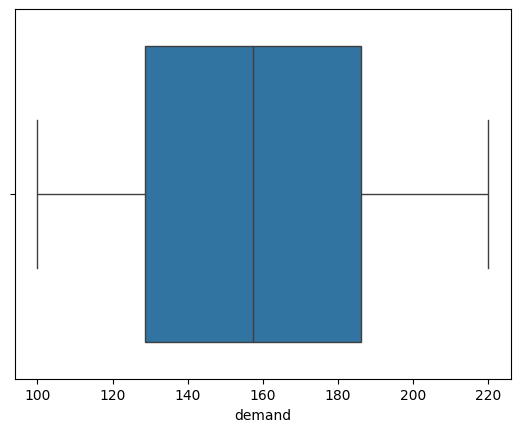

In [7]:
sns.boxplot(x=df["demand"])
plt.show()


- Consistency
- Check if time-series is continuous (no missing months).


In [8]:
df = df.set_index("date_column").asfreq("MS")  # monthly frequency

Exploratory Data Analysis (EDA)

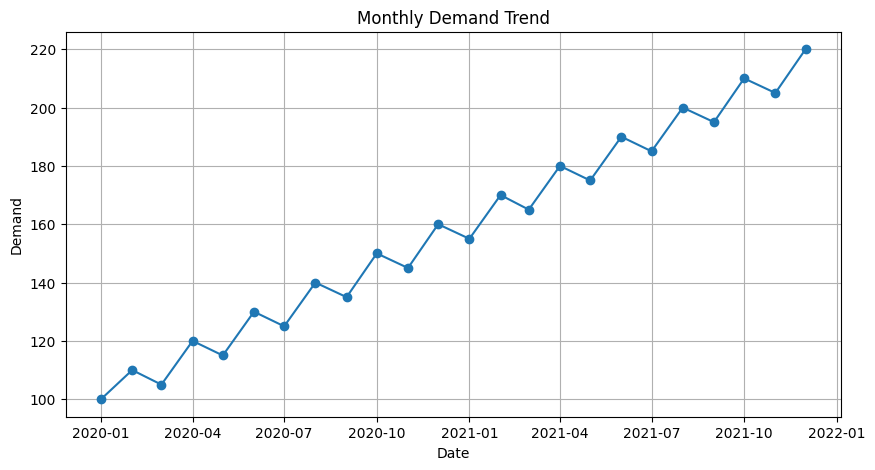

In [13]:
plt.figure(figsize=(10,5))
plt.plot(df["date_column"], df["demand"], marker="o")
plt.title("Monthly Demand Trend")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.grid(True)
plt.show()

 Feature Engineering
Create lag features, rolling averages, and time-based features.



In [14]:
df["lag1"] = df["demand"].shift(1)
df["lag2"] = df["demand"].shift(2)
df["lag3"] = df["demand"].shift(3)
df["rolling_mean_3"] = df["demand"].rolling(3).mean()
df["month"] = df["date_column"].dt.month
df["year"] = df["date_column"].dt.year
df = df.dropna()

Train-Test Split

In [15]:
train = df[df["year"] == 2020]
test = df[df["year"] == 2021]

X_train = train[["lag1","lag2","lag3","rolling_mean_3","month"]]
y_train = train["demand"]
X_test = test[["lag1","lag2","lag3","rolling_mean_3","month"]]
y_test = test["demand"]

Machine Learning Models
Linear Regression


In [16]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

Random Forest

In [17]:
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Evaluation

In [18]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    print(f"{name} -> MAE:{mae:.2f}, RMSE:{rmse:.2f}, MAPE:{mape:.2f}%")

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")

Linear Regression -> MAE:0.68, RMSE:0.68, MAPE:0.36%
Random Forest -> MAE:38.24, RMSE:41.37, MAPE:19.74%


- MAE → average error.
- RMSE → penalizes large errors.
- MAPE → % error, easy for business context.


Visualization

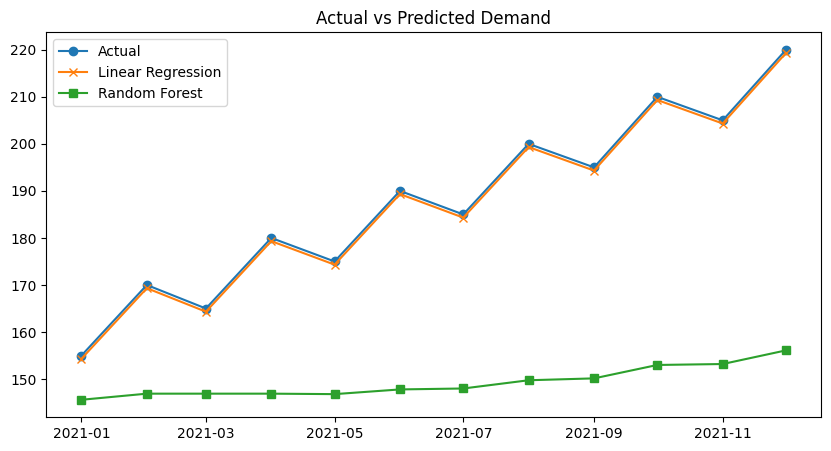

In [19]:
plt.figure(figsize=(10,5))
plt.plot(test["date_column"], y_test, label="Actual", marker="o")
plt.plot(test["date_column"], y_pred_lr, label="Linear Regression", marker="x")
plt.plot(test["date_column"], y_pred_rf, label="Random Forest", marker="s")
plt.legend()
plt.title("Actual vs Predicted Demand")
plt.show()

 Feature Importance (Random Forest)

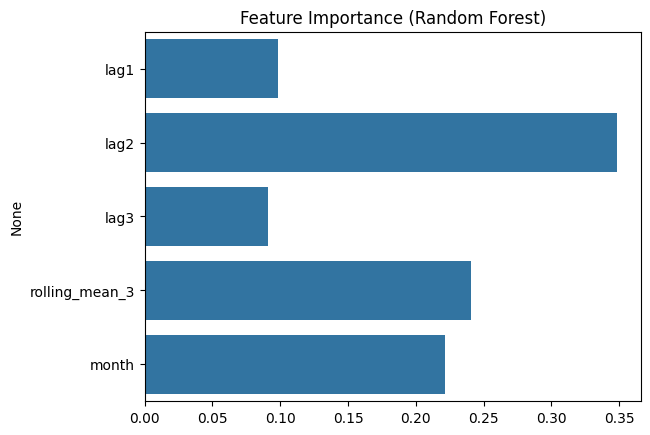

In [20]:
sns.barplot(x=rf.feature_importances_, y=X_train.columns)
plt.title("Feature Importance (Random Forest)")
plt.show()

ARIMA Model

c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


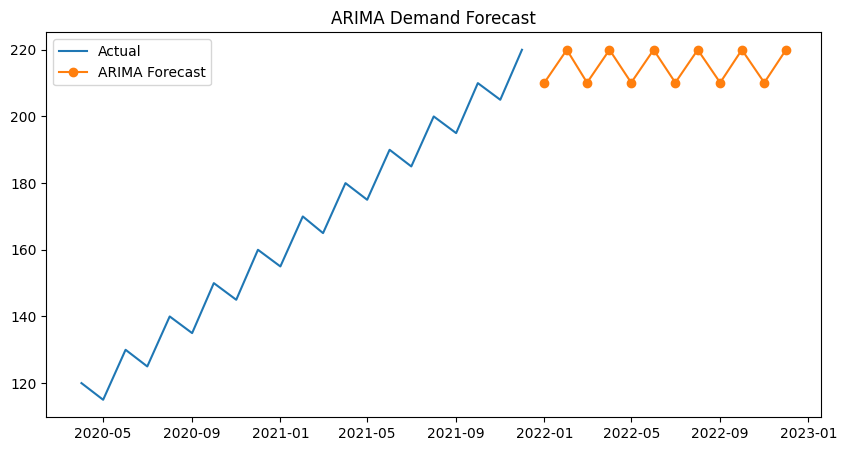

In [21]:
ts = df.set_index("date_column")["demand"]
model_arima = sm.tsa.ARIMA(ts, order=(1,1,1))
results_arima = model_arima.fit()
forecast_arima = results_arima.forecast(steps=12)

plt.figure(figsize=(10,5))
plt.plot(ts, label="Actual")
plt.plot(pd.date_range("2022-01-01", periods=12, freq="MS"), forecast_arima, label="ARIMA Forecast", marker="o")
plt.legend()
plt.title("ARIMA Demand Forecast")
plt.show()

Prophet Model

23:56:18 - cmdstanpy - INFO - Chain [1] start processing
23:56:23 - cmdstanpy - INFO - Chain [1] done processing


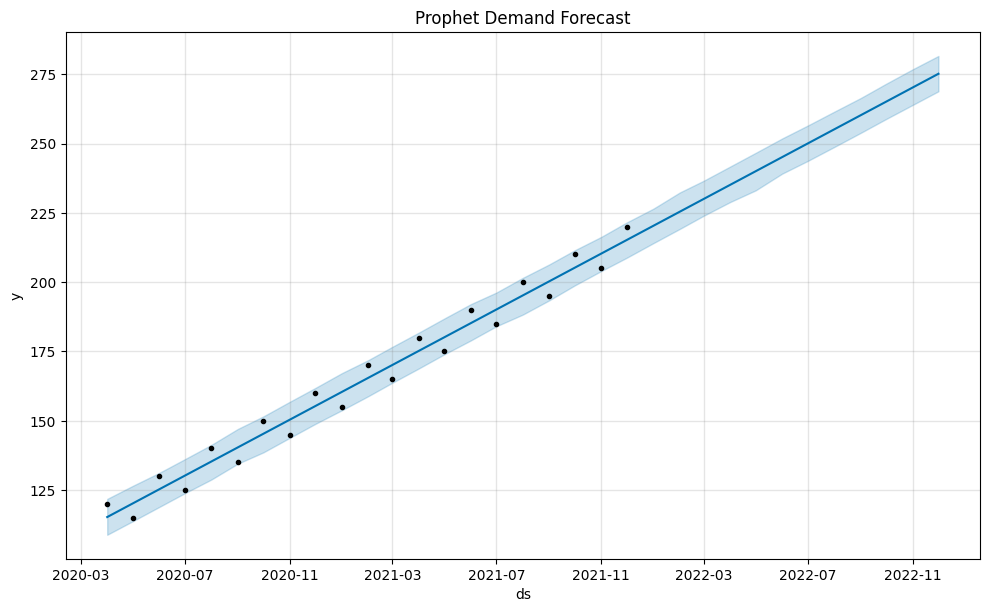

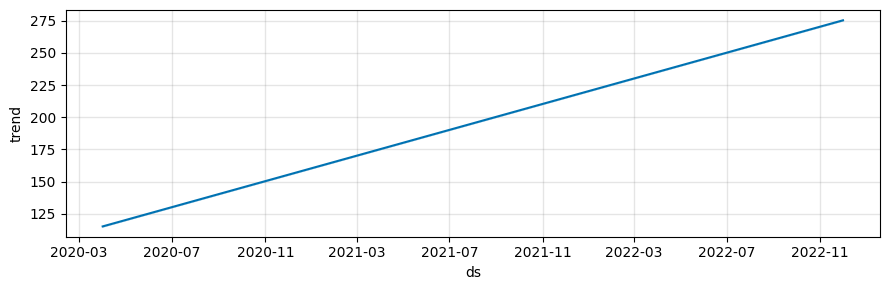

In [22]:
prophet_df = df[["date_column","demand"]].rename(columns={"date_column":"ds","demand":"y"})
model_prophet = Prophet()
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=12, freq="MS")
forecast = model_prophet.predict(future)

model_prophet.plot(forecast)
plt.title("Prophet Demand Forecast")
plt.show()

model_prophet.plot_components(forecast)
plt.show()